In [1]:
import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import scipy.special as sp
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm

In [2]:
def CvM_stat(x, cdf):
    k, n = x.shape
    y = np.sort(cdf(x), axis=1)
    sub = (2 * np.arange(1, n + 1) - 1) / (2 * n)
    sub = np.tile(sub, (k, 1))
    t = 1 / (12 * n) + np.sum((y - sub) ** 2, axis=1)
    return t

In [3]:
def AD_stat(X, f):
    k, n = X.shape
    Y = f(np.sort(X, axis=1))
    np.clip(Y, 1e-9, 1 - 1e-9, out=Y)
    logsum = np.log(Y) + np.log(1 - np.flip(Y, axis=1))
    coeffs = (2 * np.arange(1, n + 1) - 1) / n
    s = logsum.dot(coeffs)
    t = -n - s
    return t

In [4]:
# K = 100_000
# N = 1_000
# X = st.uniform.rvs(size=(K, N));

In [5]:
#AD = np.sort(AD_stat(X, st.uniform.cdf))

In [6]:
#np.save('AD_test_statistic', AD)

In [4]:
CvM = np.load('CvM_test_statistic.npy')
AD = np.load('AD_test_statistic.npy')

### Задание 1

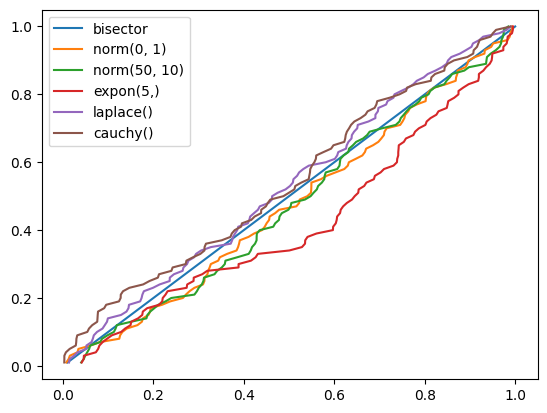

In [6]:
N = 100
K = 100
RVs = [st.norm(0, 1), st.norm(50, 10), st.expon(5), st.laplace(), st.cauchy()]
unisplit = np.arange(1, K + 1) / K
plt.plot(unisplit, unisplit, label='bisector')

for rv in RVs:
    X = rv.rvs((K, N))
    T = AD_stat(X, rv.cdf)
    p_value = 1 - np.searchsorted(AD, T, side='right') / AD.size
    p_value = np.sort(p_value)
    plt.plot(p_value, unisplit, label=f"{rv.dist.name}{rv.args}")
plt.legend();

### Задание 2

In [6]:
class Mixture:
    def __init__(self, rv, p):
        n = len(rv)
        m = len(p)
        assert n == m, f"Wrong sizes while creating Mixture object: {n} != {m}"
        self.n = n
        self.rv = rv
        self.selector = st.rv_discrete(values=(np.arange(n), p))
    
    def rvs(self, shape):
        res = np.zeros(shape)
        choice = self.selector.rvs(size=shape)
        dist_ind, counts = np.unique(choice, return_counts=True)
        for i, cnt in zip(dist_ind, counts):
            res[choice == i] = self.rv[i].rvs(cnt)
        return res

In [14]:
def plot_pvalues(X, hyp, ax):
    k, n = X.shape
    unisplit = np.arange(1, k + 1) / k
    ax.plot(unisplit, unisplit, label='bisector', ls='dashed')


    # Колмогорова-Смирнова
    p_value = st.kstest(X, hyp.cdf, axis=1).pvalue
    p_value = np.sort(p_value)
    ax.plot(p_value, unisplit, label="KS")

    # Крамера-фон Мизеса
    t_cvm = CvM_stat(X, hyp.cdf)
    p_value = 1 - np.searchsorted(CvM, t_cvm, side='right') / AD.size
    p_value = np.sort(p_value)
    ax.plot(p_value, unisplit, label="CvM")
    
    # Хи-квадрат
    num_of_bins = max(3, int(max(mt.log(n, 2), n ** 0.2)))
    alpha = 1 / num_of_bins
    bins = hyp.ppf(alpha * np.arange(1, num_of_bins))
    p_value = np.zeros(k)
    for i in range(k):
        f_obs = np.bincount(np.digitize(X[i], bins), minlength=num_of_bins)
        p_value[i] = st.chisquare(f_obs).pvalue
    p_value = np.sort(p_value)
    ax.plot(p_value, unisplit, label="Chi2")

    # Андерсона-Дарлинга
    t_ad = AD_stat(X, hyp.cdf)
    p_value = 1 - np.searchsorted(AD, t_ad, side='right') / AD.size
    p_value = np.sort(p_value)
    ax.plot(p_value, unisplit, label="AD")

    ax.legend()

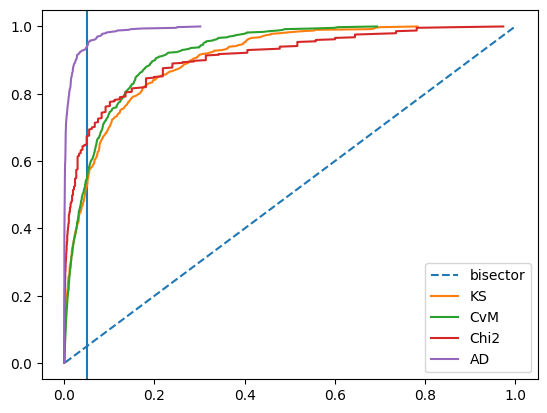

In [15]:
p = 0
rv = Mixture([st.norm(0, 1), st.norm(0, 3**0.5)], [p, 1 - p])

N = 40
K = 500
X = rv.rvs((K, N))

fig = plt.figure()
ax = fig.add_subplot()
ax.axvline(0.05)
plot_pvalues(X, st.norm(0, 1), ax)

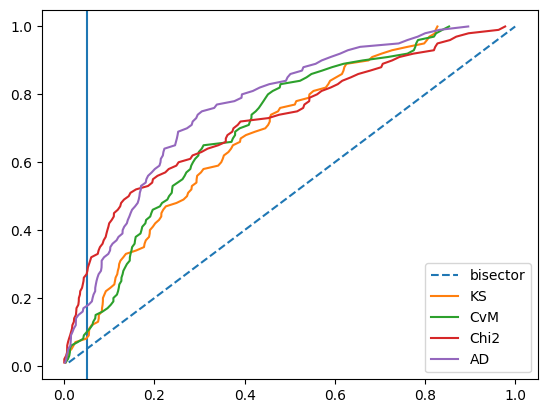

In [33]:
mu = 0.1
rv = Mixture([st.norm(mu, 1), st.norm(-mu, 1)], [0.5, 0.5])

N = 100_000
K = 100
X = rv.rvs((K, N))

fig = plt.figure()
ax = fig.add_subplot()
ax.axvline(0.05)
plot_pvalues(X, st.norm(0, 1), ax)

### Задание 3

In [7]:
grid = np.linspace(0, 1, 30)
N = 40
K = 500

hyp = st.norm(0, 1)
n = N
k = K

alpha = 0.05

d = {"KS": [], "CvM": [], "Chi2": [], "AD": []}
for p in grid:
    rv = Mixture([st.norm(0, 1), st.norm(0, 3**0.5)], [p, 1 - p])
    X = rv.rvs((K, N))
    
    # Колмогорова-Смирнова
    p_value = st.kstest(X, hyp.cdf, axis=1).pvalue
    power = np.sum(p_value < alpha) / K
    d["KS"].append(power)

    # Крамера-фон Мизеса
    t_cvm = CvM_stat(X, hyp.cdf)
    power = np.sum(p_value < alpha) / K
    d["CvM"].append(power)
    
    # Хи-квадрат
    num_of_bins = max(3, int(max(mt.log(n, 2), n ** 0.2)))
    alpha = 1 / num_of_bins
    bins = hyp.ppf(alpha * np.arange(1, num_of_bins))
    p_value = np.zeros(k)
    for i in range(k):
        f_obs = np.bincount(np.digitize(X[i], bins), minlength=num_of_bins)
        p_value[i] = st.chisquare(f_obs).pvalue
    power = np.sum(p_value < alpha) / K
    d["Chi2"].append(power)

    # Андерсона-Дарлинга
    t_ad = AD_stat(X, hyp.cdf)
    p_value = 1 - np.searchsorted(AD, t_ad, side='right') / AD.size
    power = np.sum(p_value < alpha) / K
    d["AD"].append(power)

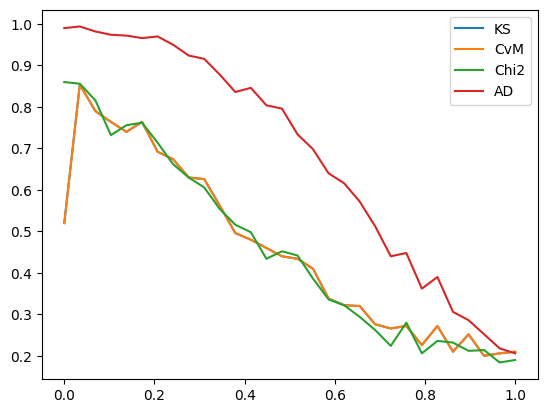

In [8]:

fig = plt.figure()
ax = fig.add_subplot()

for name, values in d.items():
    #if name != "KS": continue
    plt.plot(grid, values, label=name)
    
ax.legend();